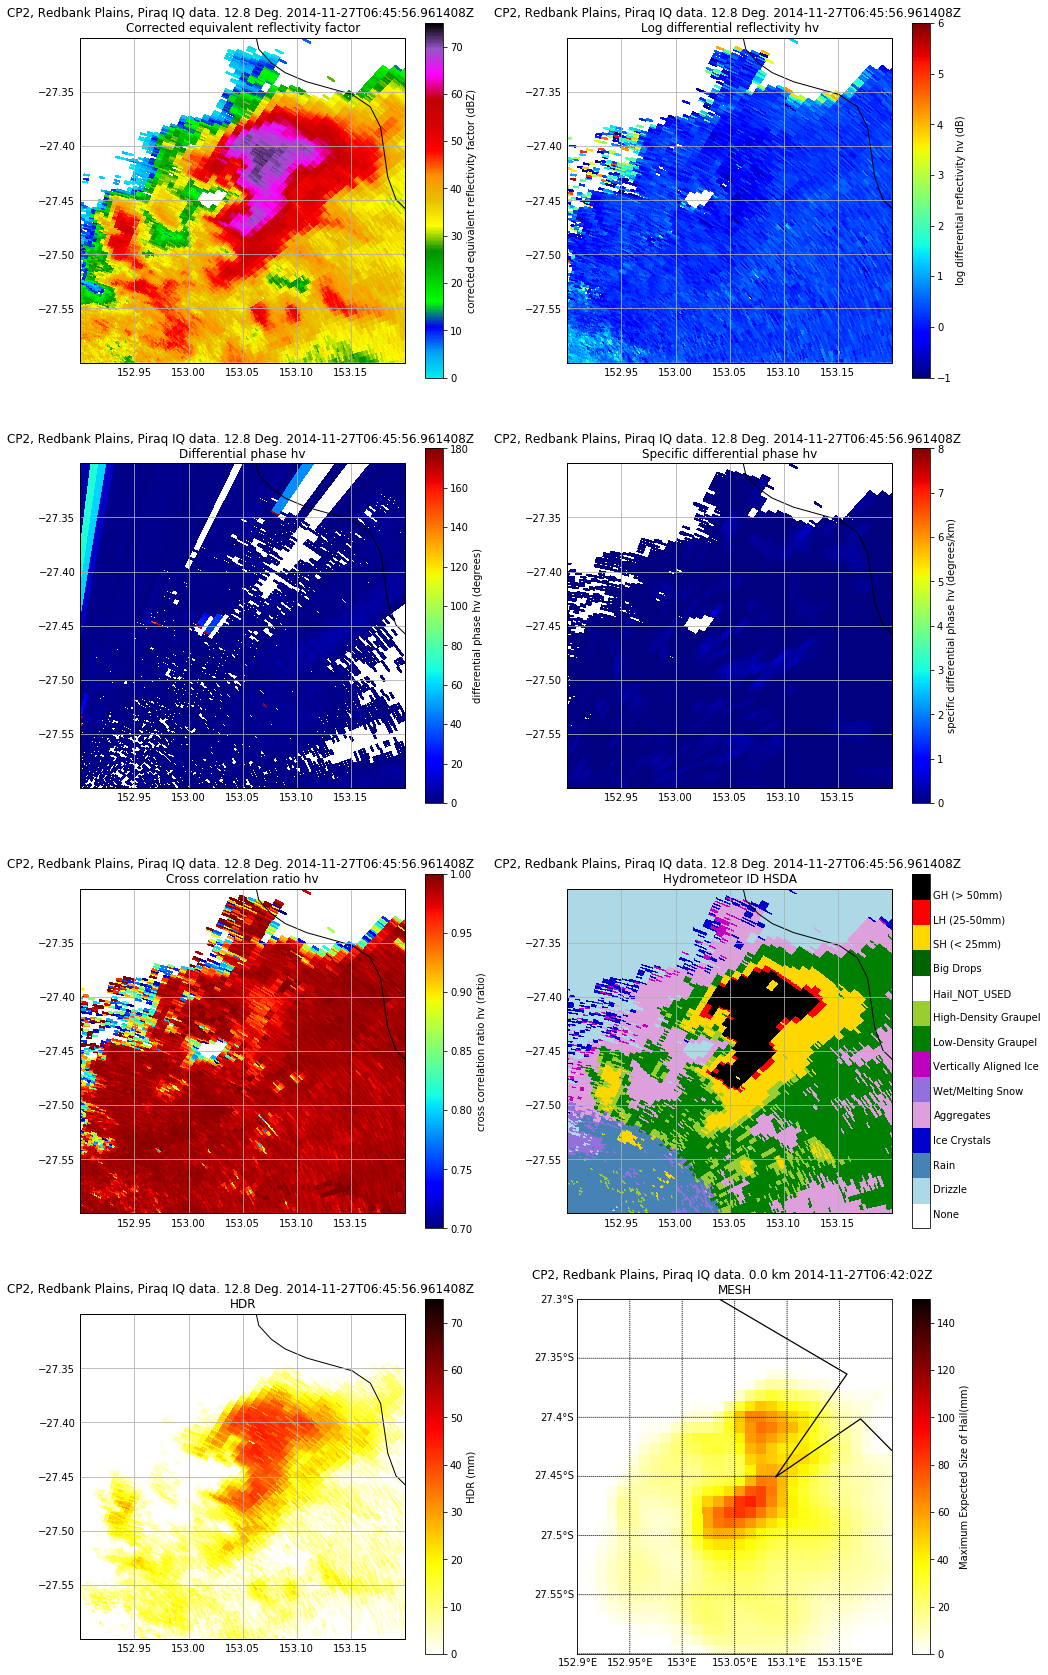

In [2]:
#imports
from __future__ import print_function
import pyart
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import numpy as np
from time import time
import os
import cartopy.crs as ccrs
import matplotlib.colors as colors

#function to generate discrete colourbar for HSDA/HCA
def adjust_csu_hsda_scheme_colorbar_for_pyart(cb):
    cb.set_ticks(np.arange(.55, 14, .9))
    cb.ax.set_yticklabels(['None','Drizzle','Rain',
                           'Ice Crystals','Aggregates','Wet/Melting Snow','Vertically Aligned Ice',
                           'Low-Density Graupel','High-Density Graupel',
                           'Hail_NOT_USED',
                           'Big Drops',
                           'SH (< 25mm)','LH (25-50mm)','GH (> 50mm)'])
    cb.ax.set_ylabel('')
    cb.ax.tick_params(length=0)
    return cb

#subplotting functions
def create_subplot(subplt_id, display, var, vmin, vmax, cmap, vol_flag):
    #radar object
    if vol_flag:
        ax = plt.subplot(subplt_id, projection=ccrs.PlateCarree())
        display.plot_ppi_map(var, sweep=sweep, vmin=vmin, vmax=vmax, cmap=cmap, 
                            mask_outside=True, ax=ax,
                            lat_lines = lat_lines, lon_lines = lon_lines, resolution = '10m',
                            max_lat = max_lat, min_lat =min_lat, min_lon = min_lon, max_lon = max_lon)
    #grid object
    else:
        ax = plt.subplot(subplt_id)
        display.plot_basemap(ax = ax, lon_lines = lon_lines, lat_lines = lat_lines,
                             max_lat = max_lat, min_lat =min_lat, min_lon = min_lon, max_lon = max_lon,
                             auto_range=False)
        display.plot_grid(var, level=level, vmin=vmin, vmax=vmax, cmap=cmap, 
                            mask_outside=True, ax=ax)

#primary function
def eight_panel_plot(vol_ffn, grid_ffn, out_fn,
                   level=0,  #used for grid object
                   sweep=0,  #used for radar object
                   var1='DBZH_CORR',  vmin1=0,   vmax1=75,  cmap1='pyart_NWSRef', vol_flag1=True,
                   var2='ZDR_CORR',   vmin2=-1,  vmax2=6,   cmap2='jet',          vol_flag2=True,
                   var3='PHI_UNF',    vmin3=0,   vmax3=180, cmap3='jet',          vol_flag3=True,
                   var4='KDP_BRINGI', vmin4=0,   vmax4=8,   cmap4='jet',          vol_flag4=True,
                   var5='RHOHV',      vmin5=0.7, vmax5=1,   cmap5='jet',          vol_flag5=True,
                   var6='HCA_HSDA',   vmin6=0,   vmax6=13,  cmap6='RdYlBu_r',     vol_flag6=True,
                   var7='HDR',        vmin7=0,   vmax7=75,  cmap7='hot_r',        vol_flag7=True,
                   var8='MESH',       vmin8=0,   vmax8=150,  cmap8='hot_r',     vol_flag8=False,
                   return_flag=False):
    
    #initalise display
    vol_radar    = pyart.io.read(vol_ffn)
    vol_display  = pyart.graph.RadarMapDisplayCartopy(vol_radar)
    grid_radar   = pyart.io.read_grid(grid_ffn)
    grid_display = pyart.graph.GridMapDisplay(grid_radar)
    
    
    #Merge HCA with HSDA
    hsda = vol_radar.fields['HSDA']['data']
    hca  = vol_radar.fields['HCA']['data']
    
    hca_hsda   = hca
    hail_mask1 = np.isin(hsda, 1)
    hail_idx1  = np.where(hail_mask1)
    hca_hsda[hail_mask1] = 11
    hail_mask2 = np.isin(hsda, 2)
    hail_idx2  = np.where(hail_mask2)
    hca_hsda[hail_mask2] = 12
    hail_mask3 = np.isin(hsda, 3)
    hail_idx3  = np.where(hail_mask3)
    hca_hsda[hail_mask3] = 13
    
    the_comments = "1: Drizzle; 2: Rain; 3: Ice Crystals; 4: Aggregates; " +\
                   "5: Wet Snow; 6: Vertical Ice; 7: LD Graupel; 8: HD Graupel; 9: NOT USED; 10: Big Drops" +\
                   "11: Small Hail (< 25 mm); 12: Large Hail (25 - 50 mm); 13: Giant Hail (> 50 mm)"
    hsda_meta   = {'data': hca_hsda, 'units': ' ', 'long_name': 'Hydrometeor classification + HSDA',
                  'standard_name': 'Hydrometeor_ID_HSDA', 'comments': the_comments}
    vol_radar.add_field('HCA_HSDA', hsda_meta, replace_existing=True) 
    
    
    fig       = plt.figure(figsize=(16, 30), facecolor='w')
    
    
    #create figures
    create_subplot(421, vol_display, var1, vmin1, vmax1, cmap1, vol_flag1)
    create_subplot(422, vol_display, var2, vmin2, vmax2, cmap2, vol_flag2)
    create_subplot(423, vol_display, var3, vmin3, vmax3, cmap3, vol_flag3)
    create_subplot(424, vol_display, var4, vmin4, vmax4, cmap4, vol_flag4)
    create_subplot(425, vol_display, var5, vmin5, vmax5, cmap5, vol_flag5)
    create_subplot(426, vol_display, var6, vmin6, vmax6, cmap6, vol_flag6)
    create_subplot(427, vol_display, var7, vmin7, vmax7, cmap7, vol_flag7)
    create_subplot(428, grid_display, var8, vmin8, vmax8, cmap8, vol_flag8)
    
    #adjust colorbar for classification
    vol_display.cbs[5] = adjust_csu_hsda_scheme_colorbar_for_pyart(vol_display.cbs[5])
    
    #output
    plt.show()
    if save_flag:
        plt.savefig(out_fn,dpi=100)
    
#create colormaps
hsda_hid_colors = ['White', 'LightBlue', 'SteelBlue', 'MediumBlue',
          'Plum','MediumPurple','m',
          'Green','YellowGreen',
          'White',
          'DarkGreen',
          'Gold','Red','Black']
hsda_cmaphid = colors.ListedColormap(hsda_hid_colors)

#set up plotting domain
sweep     = 7
level     = 0
max_lat   = -27.3
min_lat   = -27.6
min_lon   = 152.9
max_lon   = 153.2
lat_lines = np.arange(-26, -29, -.05)
lon_lines = np.arange(151, 154, .05)

#paths
vol_ffn   = '/g/data1a/kl02/jss548/hail-research/processed_data/CP2_20141127/CP2_20141127_064202_processed.nc'
grid_ffn  = '/g/data1a/kl02/jss548/hail-research/processed_data/CP2_20141127/CP2_20141127_064202_meshgrids.nc'
save_flag = False
img_ffn   = 'image_out/CP2_20141127_064202.png'

#generate plot
eight_panel_plot(vol_ffn, grid_ffn, img_ffn, cmap6=hsda_cmaphid)             